In [1]:
#Mounting on co-lab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/XD2_Net_BPIC_2012') # change folder name


Mounted at /content/drive


### Setup of the Environment

In [2]:
#!pip install --upgrade plotly
!pip install -q -U keras-tuner --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 44.6 MB/s eta 0:00:00


In [3]:
#Import of Libaries

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy.ma.core import argmax

#Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import KMeans


#Model Building and Explanations
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend, Model, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
import keras_tuner as kt #hyperparameter tuning
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, f1_score
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


#custom functions
from functions.data_proc import *
from functions.experiment_setup import *
from functions.generate_inputs import *
from functions.model import *


Using TensorFlow backend


### Setting up experiment parameters

In [4]:
#Experimental parameters
prediction = 'los' # 'disposition'
experiment =  'mimicel_2hrs'
timelapsed = 'total'


#Directories
MY_WORKSPACE_DIR = "/content/drive/My Drive/XD2Net_CaseStudy"
MILESTONE_DIR = MY_WORKSPACE_DIR+'/'+experiment+'/'+prediction+'/'

#Dataset
file_name = os.path.join(os.path.join(MY_WORKSPACE_DIR,'MIMICEL_PREPROCESSING'),'mimicel_pred_v3.csv')
log_name = 'mimicel'


#saving parameters to a dictionary
args = get_parameters(MILESTONE_DIR, MY_WORKSPACE_DIR, prediction, experiment, file_name, log_name,None)




In [5]:
buckets =['All'] #['5','10','15','20','20+']


### Load Data

In [6]:
#Load data

log_df = pd.read_csv(args['file_name'])
log_df = log_df.reset_index(drop=True)


In [7]:
log_df.head()

,stay_id,timestamps,activity,Abnormal_ANC,Abnormal_Eosinophils,Abnormal_Glucose,Abnormal_Hematocrit,Abnormal_Hemoglobin,Abnormal_Lymphocytes,Abnormal_MCH,...,med_method_Nebulaize,med_method_Solution,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_category,chiefcomplaint_flag,hour,patient_count
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 20:00:00,6
1,30000012,2126-02-14 20:22:01,Triage in the ED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 20:00:00,6
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 22:00:00,6
3,30000012,2126-02-14 22:22:00,Medicine reconciliation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 22:00:00,6
4,30000012,2126-02-14 22:26:00,Lab test result,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,Psychological,NaN,2126-02-14 22:00:00,6


In [8]:
#replacing nan values

#acuity: replace with 3, #chiefcomplaint_flag: replace with 'none'
log_df['acuity']= log_df['acuity'].fillna(3)
log_df['chiefcomplaint_flag'] = log_df['chiefcomplaint_flag'].fillna('None')
log_df['chiefcomplaint_category'] = log_df['chiefcomplaint_category'].fillna('Unclassified')


In [9]:
log_df.loc[log_df['activity'] != 'Enter the ED',['temperature_in_ref', 'heartrate_in_ref', 'resprate_in_ref',
       'o2sat_in_ref', 'sbp_in_ref', 'dbp_in_ref']] = 0.5-log_df.loc[log_df['activity'] != 'Enter the ED',['temperature_in_ref', 'heartrate_in_ref', 'resprate_in_ref',
       'o2sat_in_ref', 'sbp_in_ref', 'dbp_in_ref']]

In [10]:
log_df[['activity','temperature_in_ref', 'heartrate_in_ref', 'resprate_in_ref',
       'o2sat_in_ref', 'sbp_in_ref', 'dbp_in_ref']].head(20)

,activity,temperature_in_ref,heartrate_in_ref,resprate_in_ref,o2sat_in_ref,sbp_in_ref,dbp_in_ref
0,Enter the ED,0.0,0.0,0.0,0.0,0.0,0.0
1,Triage in the ED,-0.5,-0.5,-0.5,-0.5,0.5,0.5
2,Medicine reconciliation,-0.5,-0.5,-0.5,-0.5,0.5,0.5
3,Medicine reconciliation,-0.5,-0.5,-0.5,-0.5,0.5,0.5
4,Lab test result,-0.5,-0.5,-0.5,-0.5,0.5,0.5
5,Lab test result,-0.5,-0.5,-0.5,-0.5,0.5,0.5
6,Lab test result,-0.5,-0.5,-0.5,-0.5,0.5,0.5
7,Vital sign check,-0.5,-0.5,-0.5,-0.5,-0.5,0.5
8,Medicine reconciliation,-0.5,-0.5,-0.5,-0.5,-0.5,0.5
9,Medicine reconciliation,-0.5,-0.5,-0.5,-0.5,-0.5,0.5


In [18]:
#eliminate the case IDs with invalid temperature readings
valid_temps = log_df.loc[(log_df['temperature']>=56.7)&(log_df['activity']=='Triage in the ED')][['stay_id']].drop_duplicates()
log_df = log_df.merge(valid_temps, on = 'stay_id')

In [19]:
log_df.columns

Index(['stay_id', 'timestamps', 'activity', 'Abnormal_ANC',
       'Abnormal_Eosinophils', 'Abnormal_Glucose', 'Abnormal_Hematocrit',
       'Abnormal_Hemoglobin', 'Abnormal_Lymphocytes', 'Abnormal_MCH',
       'Abnormal_MCHC', 'Abnormal_Neutrophils', 'Abnormal_Other',
       'Abnormal_RBC', 'Abnormal_Urea_Nitrogen', 'Abnormal_WBC',
       'Abnormal_all', 'All_tests', 'All_test_results', 'activity_index',
       'transition', 'loop_len_min', 'enter_time', 'discharge_time',
       'disposition', 'los_min', 'time_elapsed_min', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'temperature_diff',
       'heartrate_diff', 'resprate_diff', 'o2sat_diff', 'sbp_diff', 'dbp_diff',
       'temperature_in_ref', 'heartrate_in_ref', 'resprate_in_ref',
       'o2sat_in_ref', 'sbp_in_ref', 'dbp_in_ref', 'name', 'name_processed',
       'medication_cat_Nausea and vomit prevension',
       'medication_cat_Fever reducer', 'medication_cat_Pain reliever',
       'medication_cat_Sedativ

In [20]:
#feature categories
cat_dynamic = ['transition']
num_dynamic = ['loop_len_min','time_elapsed_min','Abnormal_ANC',
       'Abnormal_Eosinophils', 'Abnormal_Glucose', 'Abnormal_Hematocrit',
       'Abnormal_Hemoglobin', 'Abnormal_Lymphocytes', 'Abnormal_MCH',
       'Abnormal_MCHC', 'Abnormal_Neutrophils', 'Abnormal_Other',
       'Abnormal_RBC', 'Abnormal_Urea_Nitrogen', 'Abnormal_WBC',
       'Abnormal_all','temperature_diff',
       'heartrate_diff', 'resprate_diff', 'o2sat_diff', 'sbp_diff', 'dbp_diff',
       'temperature_in_ref', 'heartrate_in_ref', 'resprate_in_ref',
       'o2sat_in_ref', 'sbp_in_ref', 'dbp_in_ref','medication_cat_Nausea and vomit prevension',
       'medication_cat_Fever reducer', 'medication_cat_Pain reliever',
       'medication_cat_Sedative', 'medication_cat_Anti-biotic',
       'medication_cat_Anti-inflamatory', 'medication_cat_Airflow improver',
       'medication_cat_Cardio medication', 'medication_cat_Reflux reliever',
       'medication_cat_Nerve pain reliever', 'medication_cat_Blood thinner',
       'medication_cat_Anti-psychotic', 'medication_cat_Multivitamin',
       'medication_cat_General anesthetic', 'medication_cat_Antihistamin',
       'medication_cat_Local anesthetic', 'medication_cat_IBS reliever',
       'med_method_Oral', 'med_method_Vial', 'med_method_IV',
       'med_method_Nebulaize', 'med_method_Solution','patient_count']
cat_static = ['arrival_transport','chiefcomplaint_category',
       'chiefcomplaint_flag']
num_static = ['acuity','pain']
activity_name = 'activity'

In [21]:


for feat in cat_dynamic:
  log_df[feat] = log_df[feat].astype('category')
for feat in cat_static:
  log_df[feat] = log_df[feat].astype('category')


log_df.head()

,stay_id,timestamps,activity,Abnormal_ANC,Abnormal_Eosinophils,Abnormal_Glucose,Abnormal_Hematocrit,Abnormal_Hemoglobin,Abnormal_Lymphocytes,Abnormal_MCH,...,med_method_Nebulaize,med_method_Solution,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_category,chiefcomplaint_flag,hour,patient_count
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,Psychological,None,2126-02-14 20:00:00,6
1,30000012,2126-02-14 20:22:01,Triage in the ED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,Psychological,None,2126-02-14 20:00:00,6
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,Psychological,None,2126-02-14 22:00:00,6
3,30000012,2126-02-14 22:22:00,Medicine reconciliation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,Psychological,None,2126-02-14 22:00:00,6
4,30000012,2126-02-14 22:26:00,Lab test result,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,Psychological,None,2126-02-14 22:00:00,6


In [35]:
#get the third quartile of los
los_unique = log_df.groupby('stay_id')['los_min'].mean().reset_index()['los_min']
los_cutoff = np.percentile(los_unique,75)
los_cutoff

501.0

In [36]:
#establish outcome

if prediction == 'los':
  log_df['outcome'] = 'N' # N - Less than median los, Y - more than median los
  log_df.loc[log_df['los_min']>=los_cutoff,'outcome'] = 'Y'
else:
  log_df['outcome'] = 'N' # N - Not Admitted, Y - Admitted
  log_df.loc[log_df['disposition']== 'ADMITTED','outcome'] = 'Y'

### Data Preprocessing

In this use case of process inspection, we are interested only at the processes which are longer than 24 hours (that is taken more than a day to process). Despite taking long (and effort), these have a very high proportion of declined loan applications, which results in waste of orgnaizational resources

In [37]:
def split_train_test(df, percentage, caseid, activity_index):


  cases = df[caseid].nunique()
  num_test_cases = int(np.round(cases*percentage))

  prefixes = pd.DataFrame(df[ caseid].unique(),columns= [ caseid])
  prefixes = prefixes.sample(frac=1).reset_index(drop=True)

  test_cases = prefixes[:num_test_cases].reset_index(drop=True)
  test_cases['index_2'] = test_cases.index

  train_cases = prefixes[num_test_cases:].reset_index(drop=True)
  train_cases['index_2'] = train_cases.index

  df_train = train_cases.merge(df,on =  caseid)
  df_train = df_train.sort_values(['index_2', activity_index], ascending = (True, True))
  df_train = df_train.drop(['index_2'],axis = 1)

  df_test = test_cases.merge(df,on = caseid)
  df_test = df_test.sort_values(['index_2', activity_index], ascending = (True, True))
  df_test = df_test.drop(['index_2'], axis = 1)

  return df_train, df_test

In [39]:
#selection of cases with > 2 hour case length
df_case_len = log_df.loc[log_df['activity']!= 'Discharge from the ED'].groupby('stay_id')['time_elapsed_min'].max().reset_index()
df_case_len = df_case_len.loc[df_case_len['time_elapsed_min'] >= 60*2][['stay_id']]

#filtering log df
log_df = log_df.merge(df_case_len, on = 'stay_id')

#generate prefixes
log_df = log_df.loc[(log_df['time_elapsed_min'] <=  60*2) & (log_df['activity']!= 'Discharge from the ED')]

#filter prefixes with < 2 events
df_event_num = log_df.groupby('stay_id')['activity_index'].max().reset_index()

#introducing buckets

buckets = ['All'] #['5','10','15','20','20+']
#bucket_max_len = #[5,10,15,20,100]
df_event_num['bucket'] ='All' #'5'

'''for i,bucket in enumerate(buckets):
  if i ==0:
    pass
  else:
    df_event_num.loc[(df_event_num['activity_index']>bucket_max_len[i-1])&(df_event_num['activity_index']<=bucket_max_len[i]),'bucket'] =buckets[i]'''


df_event_num = df_event_num.loc[df_event_num['activity_index'] >= 2][['stay_id','bucket']]
#filtering prefixes

log_df = log_df.merge(df_event_num, on = 'stay_id')


In [41]:
#split test train
log_df_train,log_df_test = pd.DataFrame(columns= log_df.columns),pd.DataFrame(columns= log_df.columns)

for bucket in buckets:
  log_df_train_temp, log_df_test_temp =  split_train_test(log_df.loc[log_df['bucket']== bucket], 0.15, 'stay_id', 'activity_index')
  log_df_train = pd.concat([log_df_train, log_df_train_temp])
  log_df_test = pd.concat([log_df_test, log_df_test_temp])





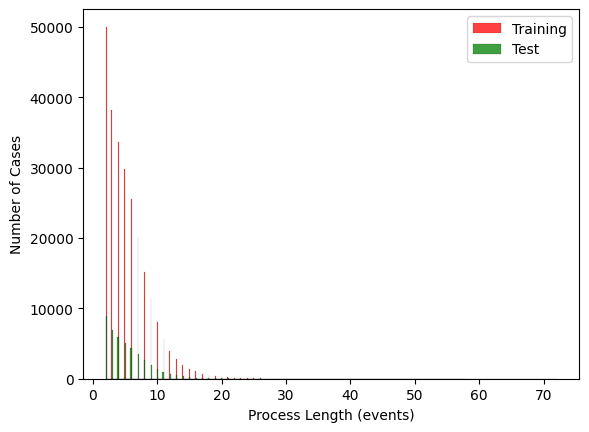

In [42]:
#distribution of number of activities
df_t1 = log_df_train.groupby('stay_id')['activity_index'].max().reset_index()
df_t2 = log_df_test.groupby('stay_id')['activity_index'].max().reset_index()

sn.histplot(df_t1['activity_index'], kde=False, label="Training", color = 'red')
sn.histplot(df_t2['activity_index'], kde=False, label="Test", color = 'green')

# Add labels and legend
plt.xlabel("Process Length (events)")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()

In [43]:
print('training dataset')
print(log_df_train.groupby(['outcome'])['stay_id'].nunique())
print("")
print('test dataset')
print(log_df_test.groupby(['outcome'])['stay_id'].nunique())
print("")


training dataset
outcome
N    179376
Y     71893
Name: stay_id, dtype: int64

test dataset
outcome
N    31697
Y    12645
Name: stay_id, dtype: int64



In [44]:
def balance(log_df,target,minority_label,id,activity_index):

  df_min = log_df[log_df[target] == minority_label]
  df_maj = log_df[log_df[target] != minority_label]

  fraction = df_min[id].nunique()/df_maj[id].nunique()

  cases_maj = pd.DataFrame(df_maj[id].unique(),columns= [id])
  cases_maj = cases_maj.sample(frac=fraction).reset_index(drop=True)


  df_maj = df_maj.merge(cases_maj,on = id)
  df_maj = df_maj.sort_values([id, activity_index], ascending = (True, True))

  df = pd.concat([df_min,df_maj])

  cases = pd.DataFrame(df[id].unique(),columns= [id])
  cases = cases.sample(frac=1).reset_index(drop=True)
  cases['index_1'] = cases.index

  df = cases.merge(df,on = id)
  df = df.sort_values(['index_1', activity_index], ascending = (True, True))
  df = df.drop(columns = 'index_1')


  return df

In [45]:
#balancing the training set
log_df_train_balanced = pd.DataFrame(columns= log_df.columns)

for bucket in buckets:
  log_df_train_temp = balance(log_df_train.loc[log_df_train['bucket']== bucket] ,'outcome','Y','stay_id','activity_index')
  log_df_train_balanced = pd.concat([log_df_train_balanced, log_df_train_temp])

log_df_train = log_df_train_balanced


print('training dataset')
print(log_df_train.groupby(['outcome'])['stay_id'].nunique())
print("")
print('test dataset')
print(log_df_test.groupby(['outcome'])['stay_id'].nunique())
print("")



training dataset
outcome
N    71893
Y    71893
Name: stay_id, dtype: int64

test dataset
outcome
N    31697
Y    12645
Name: stay_id, dtype: int64



In [46]:
#saving event log files
file_name_train_log = os.path.join(MILESTONE_DIR,log_name+'_log_df_train.csv')
log_df_train.to_csv(file_name_train_log)

file_name_test_log = os.path.join(MILESTONE_DIR,log_name+'_log_df_test.csv')
log_df_test.to_csv(file_name_test_log)


In [47]:
#removing some of the raws that are not necessary for the process
#'Enter the ED', 'Triage in the ED', 'Medicine reconciliation-> Medicine reconciliation' loops that happened at the same time

log_df_train['drop_raws'] = 0
log_df_train.loc[(log_df_train['activity']=='Enter the ED') | (log_df_train['activity']=='Triage in the ED')| ((log_df_train['transition']=='Medicine reconciliation->Medicine reconciliation') & (log_df_train['loop_len_min']==0 )),'drop_raws']= 1
log_df_train = log_df_train.loc[log_df_train['drop_raws'] == 0]

log_df_test['drop_raws'] = 0
log_df_test.loc[(log_df_test['activity']=='Enter the ED') | (log_df_test['activity']=='Triage in the ED')| ((log_df_test['transition']=='Medicine reconciliation->Medicine reconciliation') & (log_df_test['loop_len_min']==0 )),'drop_raws']= 1
log_df_test = log_df_test.loc[log_df_test['drop_raws'] == 0]


log_df_train.head(10)

,stay_id,timestamps,activity,Abnormal_ANC,Abnormal_Eosinophils,Abnormal_Glucose,Abnormal_Hematocrit,Abnormal_Hemoglobin,Abnormal_Lymphocytes,Abnormal_MCH,...,pain,acuity,chiefcomplaint,chiefcomplaint_category,chiefcomplaint_flag,hour,patient_count,outcome,bucket,drop_raws
2,37204815,2126-06-21 13:48:00,Vital sign check,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,1.0,"COUGH, FEVER",General and Unspecified,None,2126-06-21 13:00:00,5,Y,All,0
3,37204815,2126-06-21 13:49:00,Lab test result,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,1.0,"COUGH, FEVER",General and Unspecified,None,2126-06-21 13:00:00,5,Y,All,0
4,37204815,2126-06-21 13:50:00,Lab test result,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,1.0,"COUGH, FEVER",General and Unspecified,None,2126-06-21 13:00:00,5,Y,All,0
5,37204815,2126-06-21 14:00:00,Lab test result,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,1.0,"COUGH, FEVER",General and Unspecified,None,2126-06-21 14:00:00,6,Y,All,0
6,37204815,2126-06-21 14:14:00,Lab test result,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,10.0,1.0,"COUGH, FEVER",General and Unspecified,None,2126-06-21 14:00:00,6,Y,All,0
7,37204815,2126-06-21 14:34:00,Lab test result,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,10.0,1.0,"COUGH, FEVER",General and Unspecified,None,2126-06-21 14:00:00,6,Y,All,0
8,37204815,2126-06-21 15:09:00,Medicine reconciliation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,1.0,"COUGH, FEVER",General and Unspecified,None,2126-06-21 15:00:00,7,Y,All,0
11,31675873,2163-07-04 11:25:00,Vital sign check,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,"Chest pain, Confusion",Cardiovascular,None,2163-07-04 11:00:00,2,N,All,0
12,31675873,2163-07-04 12:39:00,Medicine reconciliation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,"Chest pain, Confusion",Cardiovascular,None,2163-07-04 12:00:00,4,N,All,0
13,31675873,2163-07-04 12:40:00,Medicine reconciliation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,"Chest pain, Confusion",Cardiovascular,None,2163-07-04 12:00:00,4,N,All,0


### Feature encoding and vectorization

##### Support Functions

In [48]:
def normalize_events(log_df,args,features): #updated in functions script
    """[summary]

    Args:
        log_df (DataFrame): The dataframe with eventlog data
        args (Dictionary): The set of parameters
        features (list): the list of feature name

    Returns:
        Dataframe: Returns a Dataframe with normalized numerical features
    """

    for feature in features:
        if args['norm_method'] == 'max':
            min_feature = np.min(log_df[feature])
            max_feature = np.max(log_df[feature])
            norm = lambda x: (x[feature]-min_feature)/(max_feature-min_feature)
            log_df['%s_norm'%(feature)] = log_df.apply(norm, axis=1)
        elif args['norm_method'] == 'lognorm':
            min_feature = np.min(log_df[feature])
            max_feature = np.max(log_df[feature])
            norm = lambda x: (x[feature]-min_feature)/(max_feature-min_feature)
            log_df['%s_norm'%(feature)] = log_df.apply(norm, axis=1)
            logit = lambda x: math.log1p(x['%s_norm'%(feature)])
            log_df['%s_norm'%(feature)] = log_df.apply(logit, axis=1)
    return log_df

In [49]:
#Feature Encoding



def encode_features(log_df_train,log_df_test):

  indexes = {}
  dynamic_indexes = {}
  static_indexes = {}


  for feat in cat_dynamic:
    feat_index = create_index(log_df_train, feat,True)
    index_feat = {v: k for k, v in feat_index.items()}
    dynamic_indexes[feat+'_index'] = feat_index
    dynamic_indexes['index_'+feat] = index_feat
  indexes ['dynamic_indexes'] = dynamic_indexes

  for feat in cat_static:
    feat_index = create_index(log_df_train, feat,False)
    index_feat = {v: k for k, v in feat_index.items()}
    static_indexes[feat+'_index'] = feat_index
    static_indexes['index_'+feat] = index_feat
  indexes ['static_indexes'] = static_indexes

  oc_index = create_index(log_df_train, 'outcome',False)
  index_oc = {v: k for k, v in oc_index.items()}
  indexes['oc_index'] = oc_index
  indexes['index_oc'] = index_oc

  #mapping the dictionary values as columns in the dataframe - train set
  for feat in cat_dynamic:
    log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['dynamic_indexes'][feat+'_index'])
    log_df_test[feat+'_index'] = log_df_test[feat].map(indexes ['dynamic_indexes'][feat+'_index'])

  for feat in cat_static:
    log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['static_indexes'][feat+'_index'])
    log_df_test[feat+'_index'] = log_df_test[feat].map(indexes ['static_indexes'][feat+'_index'])

  log_df_train['oc_index'] = log_df_train['outcome'].map(indexes ['oc_index'])
  log_df_test['oc_index'] = log_df_test['outcome'].map(indexes ['oc_index'])

  #change - we avoid normalization at this point, instead do it at the feature construction level
  '''#------------------------------------------------------------------------------------------------
  #Normalizing Numerical features
  numerical_features = num_dynamic.copy()
  numerical_features.extend(num_static)

  log_df_train = normalize_events(log_df_train,args,numerical_features)
  log_df_test = normalize_events(log_df_test,args,numerical_features)'''

  return log_df_train, log_df_test, indexes



In [50]:
log_df_train, log_df_test, indexes = encode_features(log_df_train, log_df_test)


<ipython-input-49-ae51004638c2>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['dynamic_indexes'][feat+'_index'])
<ipython-input-49-ae51004638c2>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['static_indexes'][feat+'_index'])
<ipython-input-49-ae51004638c2>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [51]:
#Data Reformatting into a dictionary

def reformat_events(log_df, indexes, cat_dynamic, num_dynamic,cat_static,num_static,caseid,activity_index):
    """Creates series of activities, roles and relative times per trace.
    Args:
        log_df: dataframe.
        ac_index (dict): index of activities.
        rl_index (dict): index of roles.
    Returns:
        list: lists of activities, roles and relative times.
    """
    log_df = log_df.to_dict('records')

    temp_data = list()
    log_df = sorted(log_df, key=lambda x: (x[caseid], x[activity_index]))
    for key, group in itertools.groupby(log_df, key=lambda x: x[caseid]):
        trace = list(group)

        temp_dict = {}
        dynamic = {}
        static = {}

        #dynamic features
        for feat in cat_dynamic:
          cd_order = [x[feat+'_index'] for x in trace]
          cd_order.reverse()
          dynamic[feat] = cd_order

        for feat in num_dynamic: #removed the _norm suffix
          nd_order = [x[feat] for x in trace]
          nd_order.reverse()
          dynamic[feat] = nd_order

        #static features
        for feat in cat_static:
          cs = max(x[feat+'_index'] for x in trace)
          static[feat] = cs

        #static features #removed the _norm suffix
        for feat in num_static:
          ns = max(x[feat] for x in trace)
          static[feat] = ns

        #outcome
        outcome = max(x['oc_index'] for x in trace)

        temp_dict['caseid'] = key
        temp_dict['dynamic'] = dynamic
        temp_dict['static'] = static
        temp_dict['outcome'] = outcome

        temp_data.append(temp_dict)

    return temp_data

In [52]:
#Data Reformatting into a dictionary

#Reformating the event log
log_train, log_test = {},{}
for bucket in buckets:

  log_train[bucket] = reformat_events(log_df_train.loc[log_df_train['bucket']== bucket], indexes,cat_dynamic, num_dynamic,cat_static,num_static,'stay_id','activity_index')
  log_test[bucket] = reformat_events(log_df_test.loc[log_df_test['bucket']== bucket], indexes,cat_dynamic, num_dynamic,cat_static,num_static,'stay_id','activity_index')



In [53]:
def vectorization(log,max_len,cat_dynamic, num_dynamic,cat_static,num_static,activity_name):


  vec = {'prefixes':dict(), 'prop':dict(),'statics':dict(),'outcome':[],'caseid':[]}
  vec['prop']['len'] = []
  for feat in cat_dynamic:
    vec['prefixes'][feat] = np.zeros((len(log), max_len))
  for feat in cat_static:
    vec['statics'][feat] = np.zeros(len(log))
  for feat in num_dynamic:
    vec['prefixes'][feat] = np.zeros((len(log), max_len))
  for feat in num_static:
    vec['statics'][feat] = np.zeros(len(log))

  for i in range(len(log)):

    trc_len =len(log[i]['dynamic'][activity_name])
    pad_len = max_len-trc_len

    if pad_len <0:
      pad_len =0

    for feat in cat_dynamic:
      vec['prefixes'][feat][i,:] = np.pad(log[i]['dynamic'][feat],(0,pad_len),mode='constant')[:max_len]

    for feat in num_dynamic:
      vec['prefixes'][feat][i,:] = np.pad(log[i]['dynamic'][feat],(0,pad_len),mode='constant')[:max_len]


    for feat in cat_static:
      vec['statics'][feat][i] = log[i]['static'][feat]

    for feat in num_static:
      vec['statics'][feat][i] = log[i]['static'][feat]


    vec['outcome'] =np.append(vec['outcome'],log[i]['outcome'])
    vec['caseid'] =np.append(vec['caseid'],log[i]['caseid'])
    vec['prop']['len'] = np.append(vec['prop']['len'],int(trc_len))


  return vec




##### Vectorization and Saving Processed Vectors

In [54]:
#Obtain the maximum trc_len and cases for each set
vec = {}

for bucket in buckets:

  trc_len_train, cases_train = lengths(log_train[bucket],'transition')
  trc_len_test, cases_test = lengths(log_test[bucket],'transition')

  max_len = max([trc_len_train,trc_len_test])
  print("trace_length: "+str(max_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

  bucket_vec = {}

  #Converting the log into a 3D Tensor
  vec_train = vectorization(log_train[bucket],max_len,cat_dynamic, num_dynamic,cat_static,num_static,'transition')
  vec_test = vectorization(log_test[bucket],max_len,cat_dynamic, num_dynamic,cat_static,num_static,'transition')

  bucket_vec ['vec_train'] = vec_train
  bucket_vec ['vec_test'] = vec_test

  vec[bucket] = bucket_vec

vec

trace_length: 71, training cases: 143786, test cases: 44342


{'All': {'vec_train': {'prefixes': {'transition': array([[ 4.,  1.,  1., ...,  0.,  0.,  0.],
           [11., 15.,  0., ...,  0.,  0.,  0.],
           [ 1.,  9., 11., ...,  0.,  0.,  0.],
           ...,
           [15.,  0.,  0., ...,  0.,  0.,  0.],
           [16.,  0.,  0., ...,  0.,  0.,  0.],
           [ 1.,  1.,  1., ...,  0.,  0.,  0.]]),
    'loop_len_min': array([[  3.,  15.,  11., ...,   0.,   0.,   0.],
           [  1.,  19.,   0., ...,   0.,   0.,   0.],
           [  1.,  24.,   1., ...,   0.,   0.,   0.],
           ...,
           [114.,   0.,   0., ...,   0.,   0.,   0.],
           [  1.,   0.,   0., ...,   0.,   0.,   0.],
           [ 29.,   5.,   3., ...,   0.,   0.,   0.]]),
    'time_elapsed_min': array([[ 83.,  80.,  65., ...,   0.,   0.,   0.],
           [ 20.,  19.,   0., ...,   0.,   0.,   0.],
           [ 84.,  83.,  59., ...,   0.,   0.,   0.],
           ...,
           [114.,   0.,   0., ...,   0.,   0.,   0.],
           [  1.,   0.,   0., ...,   0

In [55]:
#Save the vectors
# saving the processed tensor
vec_file = os.path.join(MILESTONE_DIR,'vec.p')
with open(vec_file, 'wb') as fp:
    pickle.dump(vec, fp, protocol=pickle.HIGHEST_PROTOCOL)

# saving indexes
index_file = os.path.join(MILESTONE_DIR,'index.p')
with open(index_file, 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving the arguements (args)
args_file = os.path.join(MILESTONE_DIR,'args.p')
with open(args_file, 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)


### Generating Case Level and Event Level Inputs

##### Loading Saved Vectors



In [ ]:
original_folder = MILESTONE_DIR


vec_file = os.path.join(original_folder,'vec.p')
with open(vec_file, 'rb') as fp:
    vec = pickle.load(fp)

index_file = os.path.join(original_folder,'index.p')
with open(index_file, 'rb') as fp:
    indexes = pickle.load(fp)

In [56]:
#feature categories
cat_dynamic = ['transition']
num_dynamic = ['loop_len_min','time_elapsed_min','Abnormal_ANC',
       'Abnormal_Eosinophils', 'Abnormal_Glucose', 'Abnormal_Hematocrit',
       'Abnormal_Hemoglobin', 'Abnormal_Lymphocytes', 'Abnormal_MCH',
       'Abnormal_MCHC', 'Abnormal_Neutrophils', 'Abnormal_Other',
       'Abnormal_RBC', 'Abnormal_Urea_Nitrogen', 'Abnormal_WBC',
       'Abnormal_all','temperature_diff',
       'heartrate_diff', 'resprate_diff', 'o2sat_diff', 'sbp_diff', 'dbp_diff',
       'temperature_in_ref', 'heartrate_in_ref', 'resprate_in_ref',
       'o2sat_in_ref', 'sbp_in_ref', 'dbp_in_ref','medication_cat_Nausea and vomit prevension',
       'medication_cat_Fever reducer', 'medication_cat_Pain reliever',
       'medication_cat_Sedative', 'medication_cat_Anti-biotic',
       'medication_cat_Anti-inflamatory', 'medication_cat_Airflow improver',
       'medication_cat_Cardio medication', 'medication_cat_Reflux reliever',
       'medication_cat_Nerve pain reliever', 'medication_cat_Blood thinner',
       'medication_cat_Anti-psychotic', 'medication_cat_Multivitamin',
       'medication_cat_General anesthetic', 'medication_cat_Antihistamin',
       'medication_cat_Local anesthetic', 'medication_cat_IBS reliever',
       'med_method_Oral', 'med_method_Vial', 'med_method_IV',
       'med_method_Nebulaize', 'med_method_Solution','patient_count']
cat_static = ['arrival_transport','chiefcomplaint_category',
       'chiefcomplaint_flag']
num_static = ['acuity','pain']
activity_name = 'activity'

##### Support Functions

In [57]:
def normalize_num_input(feat_vec,method = None): #updated in functions script

  min_feature = np.min(feat_vec)
  max_feature = np.max(feat_vec)
  range = (max_feature-min_feature)
  if range == 0:
    feat_vec_temp = (feat_vec-min_feature)
  else:
    feat_vec_temp = (feat_vec-min_feature)/range

  if method == 'max':
    norm_feat_vec = feat_vec_temp

  elif method == 'lognorm':
    norm_feat_vec = np.log1p(feat_vec_temp)

  else:
    norm_feat_vec = feat_vec

  return norm_feat_vec


In [58]:
def get_filtered_num_input(vec,feat, indexes, transition):

  feat_vec = vec['prefixes'][feat]
  transition_vec = vec['prefixes']['transition']

  boolean_array = (transition_vec == indexes['dynamic_indexes']['transition_index'][transition])
  filtered_feat_vec = np.where(boolean_array, feat_vec, 0)

  return filtered_feat_vec


In [59]:
from tables.table import NoSuchNodeError

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inputs_train = {}
inputs_test = {}


#Generating Training inputs

#Event-level input and aggregated input

def get_event_ag_inputs (vec, max_len, indexes,cat_dynamic,num_dynamic, norm_method = None):

  for i,feat in enumerate(cat_dynamic):

    feat_index = indexes['dynamic_indexes'][feat+'_index']
    feat_ohe = to_categorical(vec['prefixes'][feat][:,:max_len], num_classes=len(feat_index)) #change

    if feat_ohe.ndim <3:
      feat_ohe =  np.reshape(feat_ohe, (feat_ohe.shape[0],1,feat_ohe.shape[1]))
    if i == 0:
      event_input = feat_ohe
    else:
      event_input = np.concatenate((event_input,feat_ohe),axis=2)

  '''#replacing the raw input values for masking
  for j,prefix_len in enumerate(vec['prop']['len']):
    event_input[j][prefix_len:,:] = 0'''



  #incorporation of numerical dynamic inputs
  norm_feats =  ['loop_len_min','time_elapsed_min', 'temperature_diff', 'heartrate_diff',
       'resprate_diff', 'o2sat_diff', 'sbp_diff', 'dbp_diff','Abnormal_ANC',
       'Abnormal_Eosinophils', 'Abnormal_Glucose', 'Abnormal_Hematocrit',
       'Abnormal_Hemoglobin', 'Abnormal_Lymphocytes', 'Abnormal_MCH',
       'Abnormal_MCHC', 'Abnormal_Neutrophils', 'Abnormal_Other',
       'Abnormal_RBC', 'Abnormal_Urea_Nitrogen', 'Abnormal_WBC',
       'Abnormal_all','patient_count']

  for i,feat in enumerate(num_dynamic):
    feat_input = vec['prefixes'][feat][:,:max_len] #change
    if feat in norm_feats:
      feat_input = normalize_num_input(feat_input,norm_method)

    feat_input = np.reshape(feat_input, feat_input.shape + (1,))

    if i == 0:
      event_input_num = feat_input
    else:
      event_input_num = np.concatenate((event_input_num,feat_input),axis=2)

  event_input = np.concatenate((event_input,event_input_num),axis=2)

  event_level_names = []

  for i,feat in enumerate(cat_dynamic):
    feat_index = indexes['dynamic_indexes'][feat+'_index']
    feat_names =  [item[0] for item in feat_index.items()]
    event_level_names = np.concatenate((event_level_names,feat_names), axis = 0)

  event_level_names = np.concatenate((event_level_names,num_dynamic), axis = 0)
  event_level_names = [item for  j in range( max_len) for item in event_level_names ]


  return event_input, event_level_names




def get_static_inputs(vec, indexes,cat_static,num_static,norm_method = None):

  input_static = []

  for i,feat in enumerate(cat_static):
    feat_index = indexes['static_indexes'][feat+'_index']
    non_val = 'UNKNOWN'
    if feat == 'chiefcomplaint_category':
      non_val = 'Other'
    elif feat == 'chiefcomplaint_flag':
      non_val = 'None'

    feat_vec = np.where(np.isnan(vec['statics'][feat]), feat_index[non_val], vec['statics'][feat])
    feat_ohe = to_categorical(feat_vec, num_classes=len(feat_index))
    if i == 0:
      input_static = feat_ohe
    else:
      input_static = np.concatenate((input_static,feat_ohe),axis = 1)


  for i,feat in enumerate(num_static):
    feat_input = vec['statics'][feat]
    feat_input = normalize_num_input(feat_input,norm_method)
    feat_input = np.reshape(feat_input, feat_input.shape + (1,))
    if len(input_static) == 0:
      input_static = feat_input
    else:
      input_static = np.concatenate((input_static,feat_input),axis = 1)

  #static feature names
  static_names = []

  for i,feat in enumerate(cat_static):
    feat_index = indexes['static_indexes'][feat+'_index']
    feat_names =  [feat+'_'+item[0] for item in feat_index.items()]
    static_names = np.concatenate((static_names,feat_names), axis = 0)

  static_names = np.concatenate((static_names,num_static), axis = 0)

  return input_static,static_names



#support aggregation functions for dynamic variables

#categorical features
#get the last value of the process prefix, excluding a specified invalid value. default value has been set to 'none'
def get_last_val(vec, indexes,feat_name, max_len,None_val = 'none'):
  cases = vec['prefixes'][feat_name].shape[0]
  arr = vec['prefixes'][feat_name][:,:max_len]
  invalid_val = indexes['dynamic_indexes'][feat_name+'_index'][None_val]

  feat_arr = np.zeros(cases)
  for i in range(cases):
    feat_arr[i] = next((item for item in arr[i] if item != invalid_val), 0)

  return feat_arr

#get the most frequently occurring value of the process prefix, excluding a specified invalid value. default value has been set to 'none'
def get_mode_val(vec, indexes,feat_name, max_len, None_val = 'none'):
  cases = vec['prefixes'][feat_name].shape[0]
  arr = vec['prefixes'][feat_name][:,:max_len]
  invalid_val = indexes['dynamic_indexes'][feat_name+'_index'][None_val]

  feat_arr = np.zeros(cases)
  for i in range(cases):
    filtered_arr = arr[i][~np.isin( arr[i],[0])]
    bins = np.bincount(filtered_arr.astype(int))
    feat_arr[i] = np.argmax(bins)

  return feat_arr

#numerical features
#get the aggregated value of a numerical prefix excluding zeros

def get_non_zero_agg(feat_vec, max_len,agg_func = 'last'):

  arr = feat_vec[:,:max_len]
  non_zero_arr = np.where(arr != 0, arr, np.nan)

  if agg_func == 'mean':
    feat_arr =  np.nanmean(non_zero_arr, axis=1)
  elif agg_func == 'max':
    max_abs_indices = np.argmax(np.abs(arr), axis=1)
    feat_arr =  arr[np.arange(arr.shape[0]),max_abs_indices]
  elif agg_func == 'min':
    feat_arr =  np.nanmin(non_zero_arr, axis=1)
  elif agg_func == 'sum':
    feat_arr = np.sum(arr, axis = 1)
  else:
    feat_arr= arr[:,0]
  return feat_arr



def get_case_level_input(vec, max_len, indexes,cat_dynamic,num_dynamic,norm_method = None):



  #aggregated feature names
  case_level_names = []
  case_input = []

  #aggregated categorical input

  #item 1 - frequency of selected dynamic inputs:
  frq_feats = ['transition']
  for i,feat in enumerate(frq_feats):

    feat_index = indexes['dynamic_indexes'][feat+'_index']
    feat_ohe = to_categorical(vec['prefixes'][feat][:,:max_len], num_classes=len(feat_index))

    if i ==0:
      case_input = np.sum(feat_ohe,axis = 1)[:,1:]
      case_input = normalize_num_input(case_input,norm_method) #normalize the frequency of the case input
    else:
      case_input_temp = np.sum(feat_ohe,axis = 1)[:,1:]
      case_input_temp = normalize_num_input(case_input_temp,norm_method)
      case_input = np.concatenate((case_input,case_input_temp),axis = 1 )

    feat_names =  ['# of_'+feat+': '+item[0] for item in feat_index.items()][1:]
    case_level_names = np.concatenate((case_level_names,feat_names), axis = 0)



  #filtered aggregated numerical inputs
  filtered_feats = ['loop_len_min']

  for i,feat in enumerate(filtered_feats):
    transitions = ['Vital sign check->Vital sign check','Medicine dispensations->Vital sign check']
    for transition in transitions:
      feat_vec = get_filtered_num_input(vec,feat, indexes, transition)

      #mean aggregated
      feat_num_mean = get_non_zero_agg(feat_vec, max_len,agg_func = 'mean')
      feat_num_mean = np.where(np.isnan(feat_num_mean), 0,feat_num_mean)
      feat_num_mean = normalize_num_input(feat_num_mean,norm_method)
      feat_num_mean = np.reshape(feat_num_mean,feat_num_mean.shape+(1,))

      case_input = np.concatenate((case_input,feat_num_mean),axis = 1 )

      case_level_names = np.append(case_level_names,'Avg('+transition+'): '+feat)

      #maximum aggregated
      feat_num_max = get_non_zero_agg(feat_vec, max_len,agg_func = 'max')
      feat_num_max = np.where(np.isnan(feat_num_max), 0,feat_num_max)
      feat_num_max = normalize_num_input(feat_num_max,norm_method)
      feat_num_max = np.reshape(feat_num_max,feat_num_max.shape+(1,))
      case_input = np.concatenate((case_input,feat_num_max),axis = 1 )

      case_level_names = np.append(case_level_names,'max('+transition+'): '+feat)

      #Last event aggregated
      feat_num_last = get_non_zero_agg(feat_vec, max_len,agg_func = 'last')
      feat_num_last = np.where(np.isnan(feat_num_last), 0,feat_num_last)
      feat_num_last = normalize_num_input(feat_num_last,norm_method)
      feat_num_last = np.reshape(feat_num_last,feat_num_last.shape+(1,))
      case_input = np.concatenate((case_input,feat_num_last),axis = 1 )

      case_level_names = np.append(case_level_names,'Last('+transition+'): '+feat)



  #aggregated numerical input (by different aggregate functions)
  norm_feats =  ['loop_len_min','time_elapsed_min', 'temperature_diff', 'heartrate_diff',
       'resprate_diff', 'o2sat_diff', 'sbp_diff', 'dbp_diff','Abnormal_ANC',
       'Abnormal_Eosinophils', 'Abnormal_Glucose', 'Abnormal_Hematocrit',
       'Abnormal_Hemoglobin', 'Abnormal_Lymphocytes', 'Abnormal_MCH',
       'Abnormal_MCHC', 'Abnormal_Neutrophils', 'Abnormal_Other',
       'Abnormal_RBC', 'Abnormal_Urea_Nitrogen', 'Abnormal_WBC',
       'Abnormal_all'] #isolate non medication related features to be aggregated and named differently

  for i,feat in enumerate(num_dynamic):

    feat_vec = vec['prefixes'][feat]

    #mean aggregated
    mean_feats = ['loop_len_min','time_elapsed_min', 'temperature_diff', 'heartrate_diff',
       'resprate_diff', 'o2sat_diff', 'sbp_diff', 'dbp_diff','temperature_in_ref', 'heartrate_in_ref', 'resprate_in_ref',
       'o2sat_in_ref', 'sbp_in_ref', 'dbp_in_ref','patient_count']

    if feat in norm_feats:
      feat_num_mean = get_non_zero_agg(feat_vec, max_len,agg_func = 'mean')
      feat_num_mean = np.where(np.isnan(feat_num_mean), 0,feat_num_mean)
      feat_num_mean = normalize_num_input(feat_num_mean,norm_method)
      feat_num_mean = np.reshape(feat_num_mean,feat_num_mean.shape+(1,))
      case_input = np.concatenate((case_input,feat_num_mean),axis = 1 )
      case_level_names = np.append(case_level_names,'avg: '+feat)

    #maximum aggregated
    max_feats = ['loop_len_min','time_elapsed_min', 'temperature_diff', 'heartrate_diff',
       'resprate_diff', 'o2sat_diff', 'sbp_diff', 'dbp_diff','temperature_in_ref', 'heartrate_in_ref', 'resprate_in_ref',
       'o2sat_in_ref', 'sbp_in_ref', 'dbp_in_ref','Abnormal_ANC',
       'Abnormal_Eosinophils', 'Abnormal_Glucose', 'Abnormal_Hematocrit',
       'Abnormal_Hemoglobin', 'Abnormal_Lymphocytes', 'Abnormal_MCH',
       'Abnormal_MCHC', 'Abnormal_Neutrophils', 'Abnormal_Other',
       'Abnormal_RBC', 'Abnormal_Urea_Nitrogen', 'Abnormal_WBC',
       'Abnormal_all','patient_count']


    if feat in max_feats:
      feat_num_max = get_non_zero_agg(feat_vec, max_len,agg_func = 'max')
      feat_num_max = np.where(np.isnan(feat_num_max), 0,feat_num_max)
      feat_num_max = normalize_num_input(feat_num_max,norm_method)
      feat_num_max = np.reshape(feat_num_max,feat_num_max.shape+(1,))
      case_input = np.concatenate((case_input,feat_num_max),axis = 1 )

      case_level_names = np.append(case_level_names,'max: '+feat)

    #total aggregated
    sum_feats = ['medication_cat_Nausea and vomit prevension',
       'medication_cat_Fever reducer', 'medication_cat_Pain reliever',
       'medication_cat_Sedative', 'medication_cat_Anti-biotic',
       'medication_cat_Anti-inflamatory', 'medication_cat_Airflow improver',
       'medication_cat_Cardio medication', 'medication_cat_Reflux reliever',
       'medication_cat_Nerve pain reliever', 'medication_cat_Blood thinner',
       'medication_cat_Anti-psychotic', 'medication_cat_Multivitamin',
       'medication_cat_General anesthetic', 'medication_cat_Antihistamin',
       'medication_cat_Local anesthetic', 'medication_cat_IBS reliever',
       'med_method_Oral', 'med_method_Vial', 'med_method_IV',
       'med_method_Nebulaize', 'med_method_Solution']

    if feat in max_feats:
      feat_num_sum = get_non_zero_agg(feat_vec, max_len,agg_func = 'sum')
      feat_num_sum = np.where(np.isnan(feat_num_sum), 0,feat_num_sum)
      feat_num_sum = normalize_num_input(feat_num_sum,norm_method)
      feat_num_sum = np.reshape(feat_num_sum,feat_num_sum.shape+(1,))
      case_input = np.concatenate((case_input,feat_num_sum),axis = 1 )

      case_level_names = np.append(case_level_names,'total: '+feat)


    #Last event aggregated
    feat_num_last = get_non_zero_agg(feat_vec, max_len,agg_func = 'last')
    feat_num_last = np.where(np.isnan(feat_num_last), 0,feat_num_last)
    feat_num_last = np.reshape(feat_num_last,feat_num_last.shape+(1,))
    case_input = np.concatenate((case_input,feat_num_last),axis = 1 )

    case_level_names = np.append(case_level_names,'Last '+feat)

  return case_input, case_level_names






In [60]:
max_len_list = []
for bucket in buckets:
  max_len_list.append(vec[bucket]['vec_train']['prefixes']['transition'].shape[1])
max_len_list

[71]

In [ ]:
indexes

In [69]:
trc_lens = log_df_train.groupby('stay_id')['transition'].size().reset_index()['transition']
max_trc_len = int(np.percentile(trc_lens,99.5))
max_trc_len

17

##### Input generation




In [70]:
inputs = {}


for i,bucket in enumerate(buckets):


  bucket_inputs = {'inputs_train':{}, 'inputs_test':{}, 'inputs_test_exp': {},'names':{}}



  max_len = max_trc_len #max_len_list[i]

  vec_train = vec[bucket]['vec_train']
  vec_test = vec[bucket]['vec_test']


  #training inputs
  event_input_train, event_level_names_train = get_event_ag_inputs(vec_train, max_len, indexes,cat_dynamic,num_dynamic,norm_method = 'lognorm')
  static_input_train, static_names_train = get_static_inputs(vec_train, indexes,cat_static,num_static,norm_method = 'lognorm')
  case_input_train, case_level_names_train = get_case_level_input(vec_train, max_len, indexes,cat_dynamic,num_dynamic,norm_method = 'lognorm')

  case_input_train = np.concatenate((case_input_train,static_input_train), axis = 1)
  case_level_names_train = np.concatenate((case_level_names_train,static_names_train), axis = 0)

  #test inputs
  event_input_test, event_level_names_test = get_event_ag_inputs(vec_test, max_len, indexes,cat_dynamic,num_dynamic,norm_method = 'lognorm')
  static_input_test, static_names_test = get_static_inputs(vec_test, indexes,cat_static,num_static,norm_method = 'lognorm')
  case_input_test, case_level_names_test = get_case_level_input(vec_test, max_len, indexes,cat_dynamic,num_dynamic,norm_method = 'lognorm')

  case_input_test = np.concatenate((case_input_test,static_input_test), axis = 1)
  case_level_names_test = np.concatenate((case_level_names_test,static_names_test), axis = 0)

  #test explainable inputs (non normalized version)
  event_input_test_exp, event_level_names_test_exp = get_event_ag_inputs(vec_test, max_len, indexes,cat_dynamic,num_dynamic,norm_method = None)
  static_input_test_exp, static_names_test_exp = get_static_inputs(vec_test, indexes,cat_static,num_static,norm_method = None)
  case_input_test_exp, case_level_names_test_exp = get_case_level_input(vec_test, max_len, indexes,cat_dynamic,num_dynamic,norm_method = None)

  case_input_test_exp = np.concatenate((case_input_test_exp,static_input_test_exp), axis = 1)




  bucket_inputs['inputs_train']['case_level'] = case_input_train
  bucket_inputs['inputs_train']['event_level'] = event_input_train
  bucket_inputs['inputs_train']['static'] = static_input_train

  bucket_inputs['inputs_test']['case_level'] = case_input_test
  bucket_inputs['inputs_test']['event_level'] = event_input_test
  bucket_inputs['inputs_test']['static'] = static_input_test

  bucket_inputs['inputs_test_exp']['case_level'] = case_input_test_exp
  bucket_inputs['inputs_test_exp']['event_level'] = event_input_test_exp
  bucket_inputs['inputs_test_exp']['static'] = static_input_test_exp

  bucket_inputs['names']['case_level'] = case_level_names_train
  bucket_inputs['names']['event_level'] = event_level_names_train

  inputs[bucket] = bucket_inputs



<ipython-input-59-78619e2374ec>:154: RuntimeWarning: Mean of empty slice
  feat_arr =  np.nanmean(non_zero_arr, axis=1)


In [72]:
 inputs['All']['inputs_test']['case_level'].shape

(44342, 201)

In [74]:
inputs['All']['inputs_test_exp']['case_level'].shape

(44342, 201)

##### Saving Processed Data and Parameters

In [75]:


#saving the inputs generated
input_file = os.path.join(MILESTONE_DIR,'inputs.pkl')
with open(input_file, 'wb') as fp:
    pickle.dump(inputs, fp, protocol=pickle.HIGHEST_PROTOCOL)







### Retrieving Saved Inputs and Outputs

##### Retrieving Saved Data and Parameters

In [ ]:
original_folder = MILESTONE_DIR #= MY_WORKSPACE_DIR+'/60_hrs/'


vec_file = os.path.join(original_folder,'vec.p')
with open(vec_file, 'rb') as fp:
    vec = pickle.load(fp)

index_file = os.path.join(original_folder,'index.p')
with open(index_file, 'rb') as fp:
    indexes = pickle.load(fp)

input_file = os.path.join(original_folder,'inputs.pkl')
with open(input_file, 'rb') as fp:
    inputs = pickle.load(fp)

file_name_train_log = os.path.join(original_folder,log_name+'_log_df_train.csv')
log_df_train = pd.read_csv(file_name_train_log)

file_name_test_log = os.path.join(original_folder,log_name+'_log_df_test.csv')
log_df_test = pd.read_csv(file_name_test_log)

<ipython-input-7-9b94682cccb6>:17: DtypeWarning: Columns (79) have mixed types. Specify dtype option on import or set low_memory=False.
  log_df_train = pd.read_csv(file_name_train_log)
<ipython-input-7-9b94682cccb6>:20: DtypeWarning: Columns (79) have mixed types. Specify dtype option on import or set low_memory=False.
  log_df_test = pd.read_csv(file_name_test_log)


##### Generating Outputs

In [76]:
outputs, cases = {},{}

for bucket in buckets:

  bucket_outputs = {}
  bucket_outputs['output_train'] = vec[bucket]['vec_train']['outcome']
  bucket_outputs['output_test'] = vec[bucket]['vec_test']['outcome']
  outputs[bucket] = bucket_outputs

  bucket_cases = {}
  bucket_cases['cases_train'] = vec[bucket]['vec_train']['caseid']
  bucket_cases['cases_test'] = vec[bucket]['vec_test']['caseid']
  cases[bucket] = bucket_cases

### Model Building And Explaining


###### XD2_Net Model

In [77]:
#Final Self Explaining Model

def xd2_net_model_build (max_len, inputs_train ,lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate,opt = None ):

  MAX_LEN = max_len

  incl_time = True
  incl_res = True

  dropout = 0.15
  #lstm_size_alpha =  hp.Int('units', min_value=32, max_value=512, step=32) #50
  l2reg=0.0001
  dropout_input = 0.15
  dropout_context=0.15

  dim_event_level = inputs_train['event_level'].shape[2]
  dim_case_level = inputs_train['case_level'].shape[1]
  dim_static = inputs_train['static'].shape[1]

  #configuring the inputs

  event_input = layers.Input(shape=(MAX_LEN,dim_event_level, ), name='event_input')
  static_input = layers.Input(shape = (dim_static,), name = 'static_input' )
  case_input = layers.Input(shape=(dim_case_level, ), name='exp_input')


  #LSTM layer with attention to process x

  alpha = layers.Bidirectional(layers.LSTM(lstm_size_alpha, return_sequences=True),
                                        name='alpha')
  alpha_dense = layers.Dense(1, kernel_regularizer=l2(l2reg))
  alpha_out = alpha(event_input)
  alpha_out = layers.TimeDistributed(alpha_dense, name='alpha_dense')(alpha_out)
  alpha_out = layers.Softmax(name='timestep_attention', axis=1)(alpha_out)


  #second LSTM layer with attention to process x - sequential


  beta = layers.Bidirectional(layers.LSTM(lstm_size_beta, return_sequences=True),
                                        name='beta')
  beta_dense = layers.Dense(dim_event_level,activation='tanh',kernel_regularizer=l2(l2reg))
  beta_out = beta(event_input)
  beta_out = layers.TimeDistributed(beta_dense, name='beta_dense')(beta_out)
  beta_out = layers.Softmax(name='feature_attention', axis=1)(beta_out)



  #Compute context vector based on attentions and raw input x
  c_t = layers.Multiply()([alpha_out, beta_out, event_input])
  c_t = layers.Lambda(lambda x: backend.sum(x, axis=1))(c_t)
  c_t = layers.concatenate([c_t,static_input],name = 'full_features')

  #contexts = layers.Dropout(dropout)(c_t)

  #Intermediate dense layer
  dense_1_dim = round(dim_case_level*dense_1_dim)

  dense_1 = layers.Dense(dense_1_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='dense_1')(c_t)

  #Dense layer to compute the explainable weights thetas

  thetas = layers.Dense(dim_case_level,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='explanation_weights')(dense_1)
  #Regression layer

  reg = layers.Multiply(name = 'regression_input')([thetas, case_input])
  #x = layers.Lambda(lambda x: backend.sum(x, axis=1))(reg)
  #reg = layers.Dropout(dropout)(reg)

  #outcome_dim = vec['outcome'].shape[1]

  #Final Output
  #act_output = tf.math.sigmoid(x, name='act_output')

  #initialize all the weights to one
  initializer = tf.keras.initializers.Ones()
  act_output = layers.Dense(1,activation='sigmoid',kernel_initializer=initializer,trainable=True, name='act_output')(reg)


  model = Model(inputs=[event_input, static_input, case_input], outputs=act_output)

  plot_model(
        model,
        to_file="XD2_net.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
    )
  #learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  #optimizer choice
#'Adam','Nadam','Adamax','Adagrad','RMSprop'
  if opt == 'Adam':
    optim = keras.optimizers.Adam(learning_rate=learning_rate)
  elif opt == 'Nadam':
    optim = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adamax':
    optim = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adagrad':
    optim = keras.optimizers.Adagrad(learning_rate=learning_rate, initial_accumulator_value=0.1, epsilon=1e-07)
  elif opt == 'RMSprop':
    optim = keras.optimizers.RMSprop(learning_rate=learning_rate)
  else:
     optim = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss={'act_output': 'binary_crossentropy'}, optimizer= optim , metrics=['accuracy'])

  return model


##### Model Training

In [78]:
def xd2_net_fit(max_len,input_train,output_train, xd2_net_model, MILESTONE_DIR, batch_size, epochs):


  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

  output_file_path = os.path.join(os.path.join(MILESTONE_DIR,
                                        'models'),'model'+
                                        '_{epoch:02d}-{val_loss:.2f}.h5')

  lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    patience=10,
                                    verbose=0,
                                    mode='auto',
                                    min_delta=0.0001,
                                    cooldown=0,
                                    min_lr=0)





  model_history = xd2_net_model.fit([input_train['event_level'][:,:max_len,:],input_train['static'],input_train['case_level']],output_train,
              validation_split=0.15,
              #validation_data=(model_val_inputs, model_val_outputs),
              verbose=1,
              callbacks=[early_stopping,lr_reducer],
              batch_size=batch_size,
              epochs=epochs)

  return model_history

##### Model Hyperparameter Tuning

In [79]:
#Hyperparameter tuning and returning the best model

def xd2_net_optimum (max_len,input_train,output_train,indexes,  opt = None):

  if opt == None:
    opt = 'Adam'

  def model_builder(hp):

    lstm_size_alpha =  hp.Int('units', min_value=10, max_value=100, step=5)
    lstm_size_beta = hp.Int('units_beta', min_value=10, max_value=100, step=5)
    dense_1_dim = hp.Choice('units_dense_1', values=[1.0, 1.25, 1.5, 1.75, 2.0])
    learning_rate = 1e-2 #hp.Choice('learning_rate', values=[1e-2, 1e-3])


    model = xd2_net_model_build (max_len, input_train ,lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate,opt)
    return model

  objective_fn =kt.Objective("val_accuracy", direction="max")
  tuner =  kt.RandomSearch(model_builder, objective=objective_fn, max_consecutive_failed_trials =20, max_trials = 10,  directory=MY_WORKSPACE_DIR)

  tuner = kt.Hyperband(model_builder,
                     objective=objective_fn,
                     max_epochs=10,
                     factor=3,
                     directory=MY_WORKSPACE_DIR,
                     overwrite=True)

  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

  tuner.search([input_train['event_level'][:,:max_len,:],input_train['static'],input_train['case_level']],output_train, epochs=10, validation_split=0.2, callbacks=[early_stopping])

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  model = tuner.hypermodel.build(best_hps)
  print(model.summary())

  return model

##### Model Testing

In [80]:
def xd2_net_test (max_len,input_test,output_test, cases_test, xd2_net_model):

  y_pred = xd2_net_model.predict([input_test['event_level'][:,:max_len,:],input_test['static'],input_test['case_level']])
  y_true = output_test

  #get the best threshold
  thresholds = [0.5]
  f1_best = 0

  for thresh in thresholds:
    y_pred_bin = y_pred > thresh
    f1 = f1_score(y_true, y_pred_bin, average='weighted')
    if f1_best < f1:
      f1_best = f1

  roc_auc = roc_auc_score(y_true, y_pred)

  target_names = ['N','Y']
  report = classification_report(y_true, y_pred_bin , target_names=target_names, output_dict=True)

  df_predictions = pd.DataFrame({'CASEID':cases_test,'GROUND_TRUTH':y_true.flatten(),'PREDICTION_PROBABILITY':y_pred.flatten(),'BEST_PREDICTION':y_pred_bin.flatten().astype(int)})

  return df_predictions, roc_auc, report


##### Model Explain

In [81]:
def xd2_net_explain (max_len,input_test, input_test_exp, output_test, cases_test, xd2_net_model, feature_names):

  #deriving the explainable model with the trained xd2-net

  xd2_net_explainable = Model(inputs=xd2_net_model.input,
              outputs=[xd2_net_model.get_layer('explanation_weights').output, xd2_net_model.get_layer('timestep_attention').output,xd2_net_model.get_layer('feature_attention').output])

  explanation_weights = xd2_net_explainable.predict([input_test['event_level'][:,:max_len,:],input_test['static'],input_test['case_level']])
  last_layer_weights = xd2_net_model.get_layer('act_output').get_weights()[0].T[0]

  #case_level explanations

  df_case_level = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','LAST_LAYER_WEIGHTS','FEATURE_VALUE_EXP'])

  df_case_level['CASEID'] = [caseid  for caseid in cases_test for i in range(input_test['case_level'].shape[1])]
  df_case_level['FEATURE'] = [feature for i in range(cases_test.shape[0]) for feature in feature_names['case_level'] ]
  df_case_level['FEATURE_VALUE'] = input_test['case_level'].flatten()
  df_case_level['FEATURE_IMPORTANCE'] = explanation_weights[0].flatten()
  df_case_level['LAST_LAYER_WEIGHTS'] =  [weight for i in range(cases_test.shape[0]) for weight in last_layer_weights]
  df_case_level['FEATURE_VALUE_EXP'] = input_test_exp['case_level'].flatten()
  print('case level ok')

  #event level explanations
  df_event_level = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','EVENT_ATTENTION','FEATURE_ATTENTION','EVENT'])

  df_event_level['CASEID'] = [caseid  for caseid in cases_test for i in range(max_len*input_test['event_level'].shape[2])]
  df_event_level['FEATURE'] = [feature for i in range(cases_test.shape[0]) for feature in feature_names['event_level'][:max_len*input_test['event_level'].shape[2]] ]
  df_event_level['FEATURE_VALUE'] = input_test['event_level'][:,:max_len,:].flatten()
  df_event_level['EVENT_ATTENTION'] = [att for att in explanation_weights[1].flatten() for i in range(input_test['event_level'].shape[2]) ]
  df_event_level['FEATURE_ATTENTION'] = explanation_weights[2].flatten()
  df_event_level['EVENT'] = [i for k in range(cases_test.shape[0]) for i in range(max_len) for j in range(input_test['event_level'].shape[2])]
  #df_event_level['FEATURE_VALUE_EXP'] = input_test_exp['event_level'][:,:max_len,:].flatten()
  print('event level ok')

  df_event_level = df_event_level.loc[df_event_level['FEATURE_VALUE'] != 0]
  df_events = df_event_level.groupby('CASEID')['EVENT'].max().reset_index()
  df_events.columns = ['CASEID','MAX_EVENTS']
  df_event_level = df_event_level.merge(df_events, on = 'CASEID')
  df_event_level['EVENT'] = df_event_level['MAX_EVENTS']+1-df_event_level['EVENT']

  return df_case_level, df_event_level






#### Feature Selection

In [ ]:
df_case_level_full = pd.read_csv(os.path.join(os.path.join(MILESTONE_DIR,
                                        'outputs'),'case_level_explanations.csv'))

df_case_level_full['bucket'] = df_case_level_full['bucket'].astype(str)

<ipython-input-86-01731f015909>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_case_level_full = pd.read_csv(os.path.join(os.path.join(MILESTONE_DIR,


In [ ]:
df_case_level_full['FEATURE_WEIGHT'] = df_case_level_full['FEATURE_IMPORTANCE']*df_case_level_full['LAST_LAYER_WEIGHTS']
top_feats = {}

for bucket in buckets:
  df_case_level_filtered = df_case_level_full.loc[df_case_level_full['bucket']== bucket]
  exp_global = df_case_level_filtered.groupby('FEATURE')['FEATURE_WEIGHT'].sum().reset_index()
  exp_global['FEATURE_WEIGHT']= exp_global['FEATURE_WEIGHT']/df_case_level_filtered['CASEID'].nunique()
  exp_global['ABS_FEATURE_WEIGHT'] = abs(exp_global['FEATURE_WEIGHT'])
  exp_global_sorted = exp_global.sort_values(by='ABS_FEATURE_WEIGHT', ascending = False).iloc[:40]

  top_feats[bucket] = np.asarray(exp_global_sorted['FEATURE'])

In [ ]:
top_feats

{'5': array(['Suicide Ideation/ Self Injury', 'Psychological',
        'arrival_transport_AMBULANCE',
        '# of_transition: Triage in the ED->Vital sign check',
        'Substance presence', 'Transfer',
        'Last medication_cat_Anti-psychotic',
        'max(Vital sign check->Vital sign check): loop_len_min',
        'Last(Vital sign check->Vital sign check): loop_len_min',
        'Endocrine', 'Last o2sat_diff', 'max: o2sat_diff', 'Digestive',
        '# of_transition: Vital sign check->Vital sign check',
        'Cardiovascular', 'Last heartrate_ref_diff',
        'Last medication_cat_Nerve pain reliever', 'Blood and Immune',
        'max: temperature_ref_diff', 'max: heartrate_ref_diff',
        'Last resprate_diff', 'Last medication_cat_Reflux reliever',
        'General: medication_cat_IBS reliever',
        'General: medication_cat_Nerve pain reliever',
        'General: med_method_Solution', 'General: patient_count',
        'max: resprate_diff', 'General: medication_cat_

In [ ]:
top_feat_index = {}
for bucket in buckets:
  top_feat_index[bucket] = np.where(np.isin(inputs[bucket]['names']['case_level'],top_feats[bucket]))[0]




In [ ]:
#generate the filtered input (replacing the original input)
for bucket in buckets:
  inputs[bucket]['names']['case_level'] = inputs[bucket]['names']['case_level'][top_feat_index[bucket]]
  inputs[bucket]['inputs_train']['case_level'] = inputs[bucket]['inputs_train']['case_level'][:, top_feat_index[bucket]]
  inputs[bucket]['inputs_test']['case_level'] = inputs[bucket]['inputs_test']['case_level'][:, top_feat_index[bucket]]

#### Test the inputs generated

In [ ]:
inputs[bucket]['names']['case_level']

array(['# of_transition: Lab test result->Lab test result',
       '# of_transition: Lab test result->Medicine dispensations',
       '# of_transition: Lab test result->Medicine reconciliation',
       '# of_transition: Lab test result->Vital sign check',
       '# of_transition: Medicine dispensations->Lab test result',
       '# of_transition: Medicine dispensations->Medicine dispensations',
       '# of_transition: Medicine dispensations->Medicine reconciliation',
       '# of_transition: Medicine dispensations->Vital sign check',
       '# of_transition: Medicine reconciliation->Lab test result',
       '# of_transition: Medicine reconciliation->Medicine dispensations',
       '# of_transition: Medicine reconciliation->Medicine reconciliation',
       '# of_transition: Medicine reconciliation->Vital sign check',
       '# of_transition: Triage in the ED->Lab test result',
       '# of_transition: Triage in the ED->Medicine dispensations',
       '# of_transition: Triage in the ED->

In [ ]:
 inputs['5']['inputs_train']['case_level'].shape

(70072, 197)

In [ ]:
inputs[bucket]['inputs_train']['event_level'][0][:,-1]

array([0.5798185 , 0.5798185 , 0.5798185 , 0.5798185 , 0.5798185 ,
       0.5798185 , 0.5798185 , 0.5798185 , 0.5798185 , 0.61903921,
       0.61903921, 0.61903921, 0.61903921, 0.61903921, 0.61903921,
       0.61903921, 0.61903921, 0.61903921, 0.61903921, 0.61903921,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [ ]:
inputs[bucket]['names']['event_level']

['none',
 'Lab test result->Lab test result',
 'Lab test result->Medicine dispensations',
 'Lab test result->Medicine reconciliation',
 'Lab test result->Vital sign check',
 'Medicine dispensations->Lab test result',
 'Medicine dispensations->Medicine dispensations',
 'Medicine dispensations->Medicine reconciliation',
 'Medicine dispensations->Vital sign check',
 'Medicine reconciliation->Lab test result',
 'Medicine reconciliation->Medicine dispensations',
 'Medicine reconciliation->Medicine reconciliation',
 'Medicine reconciliation->Vital sign check',
 'Triage in the ED->Lab test result',
 'Triage in the ED->Medicine dispensations',
 'Triage in the ED->Medicine reconciliation',
 'Triage in the ED->Vital sign check',
 'Vital sign check->Lab test result',
 'Vital sign check->Medicine dispensations',
 'Vital sign check->Medicine reconciliation',
 'Vital sign check->Vital sign check',
 'loop_len_min',
 'time_elapsed_min',
 'Abnormal_ANC',
 'Abnormal_Eosinophils',
 'Abnormal_Glucose',
 '

In [ ]:
#model explaining
vec_test = vec[bucket]['vec_test']
inputs_test_exp = {}

event_input_test_exp, event_level_names_test_exp = get_event_ag_inputs(vec_test, max_len, indexes,cat_dynamic,num_dynamic,norm_method = None)
static_input_test_exp, static_names_test_exp = get_static_inputs(vec_test, indexes,cat_static,num_static,norm_method = None)
case_input_test_exp, case_level_names_test_exp = get_case_level_input(vec_test, max_len, indexes,cat_dynamic,num_dynamic,norm_method = None)

inputs_test_exp['case_level'] = case_input_test_exp
inputs_test_exp['event_level'] = event_input_test_exp
inputs_test_exp['static'] = static_input_test_exp

case_input_test_exp = np.concatenate((case_input_test,static_input_test_exp), axis = 1)
case_level_names_test_exp = np.concatenate((case_level_names_test_exp,static_names_test_exp), axis = 0)

<ipython-input-73-8d379f59104e>:154: RuntimeWarning: Mean of empty slice
  feat_arr =  np.nanmean(non_zero_arr, axis=1)


In [ ]:
inputs_test_exp['case_level'].shape

(53646, 157)

In [ ]:
case_level_names_test_exp

array(['# of_transition: Lab test result->Lab test result',
       '# of_transition: Lab test result->Medicine dispensations',
       '# of_transition: Lab test result->Medicine reconciliation',
       '# of_transition: Lab test result->Vital sign check',
       '# of_transition: Medicine dispensations->Lab test result',
       '# of_transition: Medicine dispensations->Medicine dispensations',
       '# of_transition: Medicine dispensations->Medicine reconciliation',
       '# of_transition: Medicine dispensations->Vital sign check',
       '# of_transition: Medicine reconciliation->Lab test result',
       '# of_transition: Medicine reconciliation->Medicine dispensations',
       '# of_transition: Medicine reconciliation->Medicine reconciliation',
       '# of_transition: Medicine reconciliation->Vital sign check',
       '# of_transition: Triage in the ED->Lab test result',
       '# of_transition: Triage in the ED->Medicine dispensations',
       '# of_transition: Triage in the ED->

In [ ]:
53546*157

8406722

In [ ]:
inputs[bucket]['inputs_test']['case_level'].shape

(53646, 199)

In [ ]:
bucket = '5'

In [ ]:
df_case_level, df_event_level = xd2_net_explain (max_len,inputs[bucket]['inputs_test'],inputs_test_exp,outputs[bucket]['output_test'], cases[bucket]['cases_test'], xd2_net_best, inputs[bucket]['names'])

1677/1677 [==============================] - 6s 3ms/step


#### Execution of the Model

In [82]:
#feature categories
cat_dynamic = ['transition']
num_dynamic = ['loop_len_min','time_elapsed_min','Abnormal_ANC',
       'Abnormal_Eosinophils', 'Abnormal_Glucose', 'Abnormal_Hematocrit',
       'Abnormal_Hemoglobin', 'Abnormal_Lymphocytes', 'Abnormal_MCH',
       'Abnormal_MCHC', 'Abnormal_Neutrophils', 'Abnormal_Other',
       'Abnormal_RBC', 'Abnormal_Urea_Nitrogen', 'Abnormal_WBC',
       'Abnormal_all','temperature_diff',
       'heartrate_diff', 'resprate_diff', 'o2sat_diff', 'sbp_diff', 'dbp_diff',
       'temperature_in_ref', 'heartrate_in_ref', 'resprate_in_ref',
       'o2sat_in_ref', 'sbp_in_ref', 'dbp_in_ref','medication_cat_Nausea and vomit prevension',
       'medication_cat_Fever reducer', 'medication_cat_Pain reliever',
       'medication_cat_Sedative', 'medication_cat_Anti-biotic',
       'medication_cat_Anti-inflamatory', 'medication_cat_Airflow improver',
       'medication_cat_Cardio medication', 'medication_cat_Reflux reliever',
       'medication_cat_Nerve pain reliever', 'medication_cat_Blood thinner',
       'medication_cat_Anti-psychotic', 'medication_cat_Multivitamin',
       'medication_cat_General anesthetic', 'medication_cat_Antihistamin',
       'medication_cat_Local anesthetic', 'medication_cat_IBS reliever',
       'med_method_Oral', 'med_method_Vial', 'med_method_IV',
       'med_method_Nebulaize', 'med_method_Solution','patient_count']
cat_static = ['arrival_transport','chiefcomplaint_category',
       'chiefcomplaint_flag']
num_static = ['acuity','pain']
activity_name = 'activity'

trc_lens = log_df_train.groupby('stay_id')['transition'].size().reset_index()['transition']
max_trc_len = int(np.percentile(trc_lens,99.5))
max_trc_len

17

In [83]:


roc_auc_list = []
results = {}

for i,bucket in enumerate(buckets):

  max_len = max_trc_len

  optim = 'Adam'

  hp_tuning_dir = os.path.join(MILESTONE_DIR,
                                        'hp_tuning')
  batch_size = 6000
  epochs = 100


  xd2_net_best = xd2_net_optimum (max_len,inputs[bucket]['inputs_train'],outputs[bucket]['output_train'],indexes,optim)
  model_history = xd2_net_fit(max_len,inputs[bucket]['inputs_train'],outputs[bucket]['output_train'], xd2_net_best, hp_tuning_dir, batch_size, epochs)
  df_predictions, roc_auc, report = xd2_net_test (max_len,inputs[bucket]['inputs_test'],outputs[bucket]['output_test'], cases[bucket]['cases_test'],xd2_net_best)

  #model explaining
  df_case_level, df_event_level = xd2_net_explain (max_len,inputs[bucket]['inputs_test'],inputs[bucket]['inputs_test_exp'],outputs[bucket]['output_test'], cases[bucket]['cases_test'], xd2_net_best, inputs[bucket]['names'])

  df_predictions['bucket'] = bucket
  df_case_level['bucket'] = bucket
  df_event_level['bucket'] = bucket

  if i == 0:
    df_predictions_full = df_predictions
    df_case_level_full, df_event_level_full = df_case_level, df_event_level
  else:
    df_predictions_full = pd.concat([df_predictions_full, df_predictions])
    df_case_level_full = pd.concat([df_case_level_full, df_case_level])
    df_event_level_full= pd.concat([df_event_level_full, df_event_level])

  roc_auc_list.append(roc_auc)
  results[bucket] = report

  print(roc_auc)
  print(report)


Trial 30 Complete [00h 06m 22s]
val_accuracy: 0.6365185379981995

Best val_accuracy So Far: 0.6382919549942017
Total elapsed time: 01h 20m 52s
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 event_input (InputLayer)    [(None, 17, 72)]             0         []                            
                                                                                                  
 alpha (Bidirectional)       (None, 17, 30)               10560     ['event_input[0][0]']         
                                                                                                  
 beta (Bidirectional)        (None, 17, 110)              56320     ['event_input[0][0]']         
                                                                                                  
 alpha_dense (TimeDistribut  (None, 17, 1)      

In [84]:
roc_auc_list

[0.6794038944751593]

In [ ]:


roc_auc = roc_auc_score(df_predictions_full['GROUND_TRUTH'], df_predictions_full['PREDICTION_PROBABILITY'])

target_names = ['N','Y']
report = classification_report(df_predictions_full['GROUND_TRUTH'], df_predictions_full['BEST_PREDICTION'] , target_names=target_names, output_dict=True)

In [ ]:

print(roc_auc )
print(report)





0.6561130408951299
{'N': {'precision': 0.7836058829579348, 'recall': 0.7116459361427215, 'f1-score': 0.7458943503977157, 'support': 64237}, 'Y': {'precision': 0.3918710397583637, 'recall': 0.4859934853420195, 'f1-score': 0.4338864755811629, 'support': 24560}, 'accuracy': 0.6492336452808091, 'macro avg': {'precision': 0.5877384613581492, 'recall': 0.5988197107423705, 'f1-score': 0.5898904129894393, 'support': 88797}, 'weighted avg': {'precision': 0.6752575406830666, 'recall': 0.6492336452808091, 'f1-score': 0.6595973650773271, 'support': 88797}}


#### Saving the Results

In [85]:


file_predictions = os.path.join(os.path.join(MILESTONE_DIR,
                                        'outputs'),'predictions.csv')
df_predictions_full.to_csv(file_predictions, index = False)

file_case_level = os.path.join(os.path.join(MILESTONE_DIR,
                                        'outputs'),'case_level_explanations.csv')
df_case_level_full.to_csv(file_case_level, index = False)

file_event_level = os.path.join(os.path.join(MILESTONE_DIR,
                                        'outputs'),'event_level_explanations.csv')
df_event_level_full.to_csv(file_event_level, index = False)

In [86]:
buckets

['All']

In [87]:
global_exp = df_case_level_full.loc[df_case_level_full['bucket']== 'All']
global_exp['FEATURE_WEIGHT'] = global_exp['FEATURE_IMPORTANCE']*global_exp['LAST_LAYER_WEIGHTS']
global_exp = global_exp.groupby('FEATURE')['FEATURE_WEIGHT'].mean().reset_index()
global_exp['FEATURE_WEIGHT_ABS'] = abs(global_exp['FEATURE_WEIGHT'])
global_exp = global_exp.sort_values(by='FEATURE_WEIGHT_ABS', ascending=False).iloc[:20]
global_exp.sort_values(by='FEATURE_WEIGHT', ascending=False)

,FEATURE,FEATURE_WEIGHT,FEATURE_WEIGHT_ABS
64,Last o2sat_in_ref,0.526371,0.526371
161,max: o2sat_diff,0.506344,0.506344
191,total: o2sat_diff,0.233978,0.233978
172,total: Abnormal_ANC,0.142565,0.142565
142,max: Abnormal_ANC,0.141830,0.141830
133,chiefcomplaint_flag_Suicide Ideation/ Self Injury,0.139340,0.139340
81,avg: Abnormal_ANC,0.129828,0.129828
98,avg: o2sat_diff,0.106618,0.106618
76,arrival_transport_AMBULANCE,0.096591,0.096591
67,Last resprate_in_ref,0.073812,0.073812
